In [2]:
# Imports :

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# 1. Loading the dataset :
# The dataset is from kaggle : # (Dataset: https://www.kaggle.com/datasets/carrie1/ecommerce-data)

data = pd.read_csv(r"C:\Users\email\Downloads\K-Means Project\data.csv", encoding='unicode_escape')  

print("Initial Data Shape:", data.shape)
print(data.head())

Initial Data Shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [5]:
# 2. Data Cleaning :

# Drop rows with missing CustomerID (since clustering is per customer)
data = data.dropna(subset=['CustomerID'])

# Remove cancelled orders (InvoiceNo starting with 'C')
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative/zero quantities and prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Create a new column for TotalAmount
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

print("Cleaned Data Shape:", data.shape)

Cleaned Data Shape: (397884, 9)


In [6]:
# 3. Aggregate Data per Customer :

customer_df = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',   # number of unique transactions
    'Quantity': 'sum',        # total items bought
    'TotalAmount': 'sum'      # total money spent
}).reset_index()

customer_df.rename(columns={'InvoiceNo': 'NumTransactions',
                            'Quantity': 'TotalQuantity',
                            'TotalAmount': 'TotalSpend'}, inplace=True)

print(customer_df.head())

   CustomerID  NumTransactions  TotalQuantity  TotalSpend
0     12346.0                1          74215    77183.60
1     12347.0                7           2458     4310.00
2     12348.0                4           2341     1797.24
3     12349.0                1            631     1757.55
4     12350.0                1            197      334.40


In [7]:
# 4. Feature Scaling :

features = ['NumTransactions', 'TotalQuantity', 'TotalSpend']
scaler = StandardScaler()
scaled = scaler.fit_transform(customer_df[features])

In [8]:
# 5. K-Means:

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(scaled)

In [10]:
# 6. Dimensionality Reduction (Prinicipal Component Analysis for Visualization) :

pca = PCA(n_components=2)
components = pca.fit_transform(scaled)
customer_df['PCA1'] = components[:,0]
customer_df['PCA2'] = components[:,1]

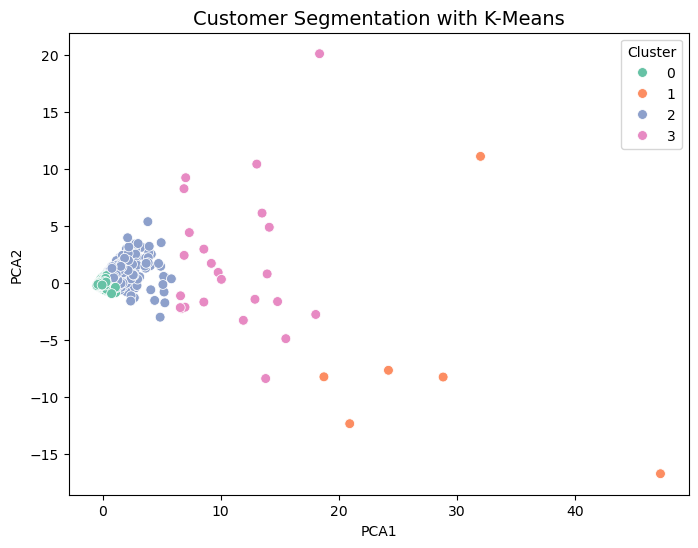

In [11]:
# 7. Visualization :

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_df, palette='Set2', s=50)
plt.title("Customer Segmentation with K-Means", fontsize=14)
plt.show()

In [12]:
# 8. Cluster Summary :

summary = customer_df.groupby('Cluster')[features].mean()
print("\nCluster Summary:")
print(summary)


Cluster Summary:
         NumTransactions  TotalQuantity     TotalSpend
Cluster                                               
0               2.817036     589.754284     986.517718
1              67.166667   94944.666667  195271.033333
2              16.394118    4199.385294    7604.762588
3              57.375000   34592.000000   51652.505000


In [16]:
# 9. Cluster Profiling :

cluster_profile = customer_df.groupby('Cluster').mean().round(2)
print(cluster_profile)



         CustomerID  NumTransactions  TotalQuantity  TotalSpend   PCA1  PCA2
Cluster                                                                     
0          15306.77             2.82         589.75      986.52  -0.24 -0.08
1          15661.67            67.17       94944.67   195271.03  28.65 -7.00
2          15239.60            16.39        4199.39     7604.76   1.53  0.94
3          15019.50            57.38       34592.00    51652.50  10.88  1.73


In [13]:
# What this project does:

# 1. We take customer transaction data (total purchases, frequency, money spent).

# 2. We scale it → apply K-Means.

# 3. We group customers into 4 segments (clusters).

In [18]:
# Typical Conclusion
# After clustering, we end up with groups like:

# High-Value Loyal Customers :

#     High money spent 💰

#     Frequent purchases 📦

#     Very important for business → focus on retention (loyalty rewards, personalized offers).

# Medium Spenders / Regulars

#     Spend moderate amounts

#     Buy often but not extravagantly

#     Potential to upsell or cross-sell.

# Occasional Bargain Buyers

#     Low spending, low frequency

#     Price-sensitive → respond to discounts/promotions.

# One-time / Inactive Customers

#     Very few purchases

#     Low engagement → need re-engagement campaigns or may not be worth targeting.

In [19]:
# From the Cluster Profiling, we can derive the following conclusion :

# Cluster 2 – Premium Customers / High-Value Loyal Customers
#     Business strategy: give them loyalty rewards, exclusive discounts, priority service.

# Cluster 0 – Regular Customers / Medium Spenders
#     Strategy: upsell / cross-sell products, encourage them to move toward premium.

# Cluster 3 – Occasional Buyers
#     Strategy: send personalized offers, seasonal discounts.

# Cluster 1 – Low-Value Customers / One-Time / Inactive
#     Strategy: email reminders, low-cost promotions, or even decide if marketing spend should be minimized.